In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# [1] Import Libraries and Load Data


In [2]:
# Import foundational libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import TensorFlow and Keras for building our neural network
# TensorFlow is the backend, and Keras is the user-friendly API to build models.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.utils import to_categorical

print("Libraries imported successfully.")

# Load the training and testing datasets
# This assumes the data is in the standard Kaggle input directory.
try:
    train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
    test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
    print("Training and testing data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Ensure you are running this in a Kaggle environment.")
    print("Creating dummy dataframes to allow the script to continue without crashing.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

# Inspect the loaded data
if not train_df.empty:
    print("\nShape of the training data:", train_df.shape)
    print("Shape of the testing data:", test_df.shape)
    print("\nFirst 5 rows of the training data:")
    display(train_df.head())

2025-07-15 12:29:02.400342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752582542.655129      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752582542.729377      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully.
Training and testing data loaded successfully.

Shape of the training data: (42000, 785)
Shape of the testing data: (28000, 784)

First 5 rows of the training data:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# [2] Prepare the Data for the CNN Model


Normalization complete.
Data reshaped. X_train shape: (42000, 28, 28, 1), X_test shape: (28000, 28, 28, 1)
Labels have been one-hot encoded. y_train shape: (42000, 10)

Displaying a few sample digits after processing:


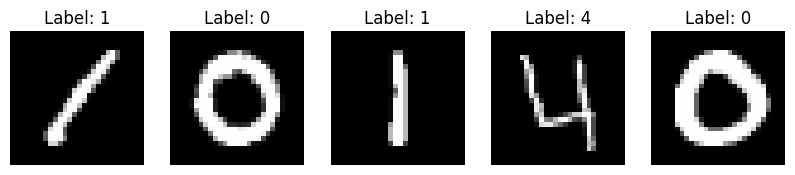

In [3]:
# Separate the labels (y) from the pixel data (X) in the training set
y_train = train_df["label"]
X_train = train_df.drop(labels = ["label"], axis = 1) 

# The test set has no labels, so it's entirely features (X)
X_test = test_df

# 1. Normalization
# We normalize the data to a 0-1 range to help the neural network converge faster.
# We divide by 255.0 (using a float) to ensure the result is a float.
X_train = X_train / 255.0
X_test = X_test / 255.0
print("Normalization complete.")

# 2. Reshape
# CNNs expect image data in the format (batch_size, height, width, color_channels).
# Our images are 28x28 pixels and grayscale (1 channel).
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
print(f"Data reshaped. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# 3. One-Hot Encoding for Labels
# We convert the labels (e.g., 5) into a vector of 10 positions with a 1 at the 5th index ([0,0,0,0,0,1,0,0,0,0]).
# This is necessary for the 'categorical_crossentropy' loss function.
y_train = to_categorical(y_train, num_classes = 10)
print(f"Labels have been one-hot encoded. y_train shape: {y_train.shape}")

# (Optional but recommended) Visualize some of the processed digits
print("\nDisplaying a few sample digits after processing:")
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # The [:,:,0] is used to remove the last dimension (channel) for plotting
    plt.imshow(X_train[i][:,:,0], cmap='gray')
    # np.argmax converts the one-hot encoded vector back to a number for the title
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.show()

# [3] Define and Compile the CNN Model


In [4]:
# Create a Sequential model, which is a linear stack of layers.
model = Sequential()

# --- Convolutional Block 1 ---
# 32 filters, each 5x5 in size. 'relu' is the activation function.
# 'padding="Same"' ensures the output image size is the same as the input.
# 'input_shape' is only needed for the first layer.
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # Dropout 25% of neurons

# --- Convolutional Block 2 ---
# We increase the number of filters to learn more complex features.
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25)) # Dropout another 25%

# --- Fully Connected Block ---
# Flatten the 2D arrays into a 1D vector before feeding to the Dense layers.
model.add(Flatten())
# A standard dense layer with 256 neurons.
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5)) # A higher dropout rate for the dense layer
# The final output layer. It has 10 neurons (one for each digit 0-9).
# 'softmax' activation gives us the probability for each class.
model.add(Dense(10, activation="softmax"))

# Compile the model
# This step configures the model for training.
# Optimizer: 'adam' is a very effective and commonly used optimizer.
# Loss Function: 'categorical_crossentropy' is the standard for multi-class classification.
# Metrics: We want to monitor the 'accuracy' during training.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
print("Model architecture built successfully.")
model.summary()

Model architecture built successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-15 12:35:48.414720: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,530 (3.39 MB)

 Trainable params: 887,530 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

# [4] Split Data, Augment, and Train the Model


Data split into training and validation sets.
Data augmentation generator is ready.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 - 142s - 240ms/step - accuracy: 0.8708 - loss: 0.3963 - val_accuracy: 0.9805 - val_loss: 0.0626
Epoch 2/20
591/591 - 143s - 242ms/step - accuracy: 0.9608 - loss: 0.1342 - val_accuracy: 0.9893 - val_loss: 0.0361
Epoch 3/20
591/591 - 137s - 232ms/step - accuracy: 0.9711 - loss: 0.0985 - val_accuracy: 0.9833 - val_loss: 0.0500
Epoch 4/20
591/591 - 136s - 230ms/step - accuracy: 0.9749 - loss: 0.0844 - val_accuracy: 0.9893 - val_loss: 0.0360
Epoch 5/20
591/591 - 137s - 232ms/step - accuracy: 0.9784 - loss: 0.0722 - val_accuracy: 0.9907 - val_loss: 0.0307
Epoch 6/20
591/591 - 138s - 233ms/step - accuracy: 0.9803 - loss: 0.0670 - val_accuracy: 0.9900 - val_loss: 0.0324
Epoch 7/20
591/591 - 138s - 233ms/step - accuracy: 0.9820 - loss: 0.0589 - val_accuracy: 0.9910 - val_loss: 0.0284
Epoch 8/20
591/591 - 128s - 217ms/step - accuracy: 0.9823 - loss: 0.0574 - val_accuracy: 0.9900 - val_loss: 0.0350
Epoch 9/20
591/591 - 139s - 235ms/step - accuracy: 0.9838 - loss: 0.0534 - val_accuracy: 0.

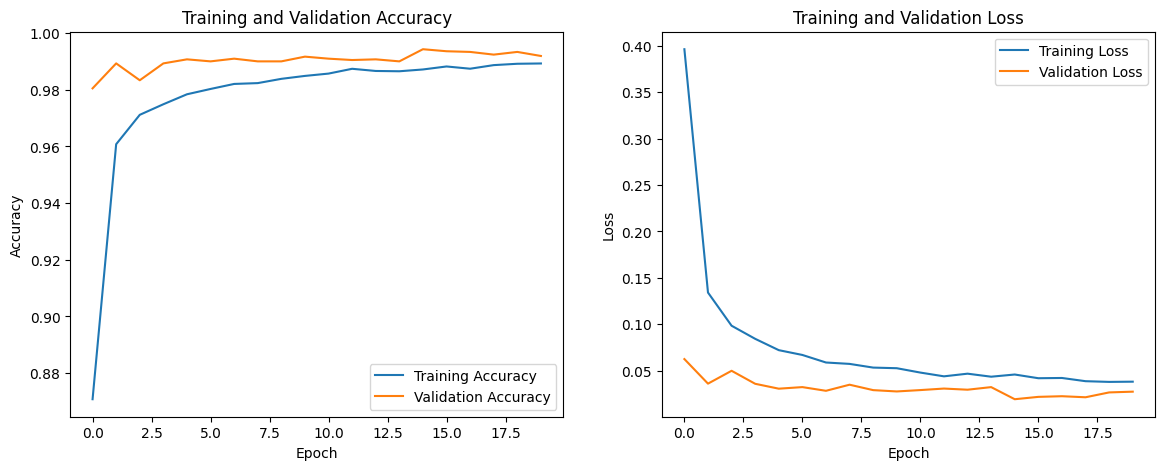

In [5]:
# Import necessary tools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Create a validation set
# We split the training data into a training set (90%) and a validation set (10%).
# The model will train on the training set and we'll check its performance on the validation set.
# random_state ensures we get the same split every time we run the code.
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)
print("Data split into training and validation sets.")

# 2. Set up Data Augmentation
# This creates more training data from the existing images by applying random transformations.
datagen = ImageDataGenerator(
        rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,       # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1) # randomly shift images vertically (fraction of total height)

datagen.fit(X_train_split)
print("Data augmentation generator is ready.")

# 3. Set training parameters
epochs = 20 # The model will see the entire dataset 20 times.
batch_size = 64 # The model will be updated after processing 64 images at a time.

# 4. Train the model
# We use the .fit() method which starts the training process.
# It will use the augmented data from our 'datagen' generator.
# This step will take some time to complete, depending on your hardware (CPU/GPU).
history = model.fit(datagen.flow(X_train_split, y_train_split, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val, y_val),
                              verbose = 2) # verbose=2 shows less output per epoch

print("\nModel training complete!")

# 5. Visualize the training history
# We can plot the accuracy and loss for both training and validation sets to see how our model learned.
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# [5] Predict on Test Data and Create Submission File


In [6]:
# 1. Make predictions on the test data
# The model.predict() method will return an array of probabilities for each class (0-9) for each image.
predictions = model.predict(X_test)

# 2. Convert probabilities to digit labels
# We use np.argmax() to find the index of the highest probability for each prediction.
# This index corresponds to the predicted digit.
predicted_labels = np.argmax(predictions, axis=1)

print("Predictions made on the test data.")

# 3. Create the submission DataFrame
# The submission file needs two columns: 'ImageId' and 'Label'.
# 'ImageId' should start from 1, not 0.
submission_df = pd.DataFrame({
    "ImageId": range(1, len(predicted_labels) + 1),
    "Label": predicted_labels
})

# Display the first few rows of our submission file to check it
print("\nFirst 5 rows of the submission file:")
display(submission_df.head())

# 4. Save the DataFrame to a CSV file
# We use index=False because Kaggle does not want the pandas DataFrame index in the submission file.
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file has been created successfully!")
print("You can now submit this file to the Digit Recognizer competition on Kaggle.")

875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step
Predictions made on the test data.

First 5 rows of the submission file:


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3



'submission.csv' file has been created successfully!
You can now submit this file to the Digit Recognizer competition on Kaggle.
